# Datos y su procesamiento
Tratamiento y buen uso de datos para evitar "garbage in, garbage out", encontrar los datos con la maxima calidad de plataformas con la maxima confianza posible
Getting data from Yahoo Finance
Getting data from Quandl

El resultado de la solicitud es un DataFrame contiene los precios diarios de apertura, precios de apertura, alta, baja y cierre (OHLC: Open, High, Low, and Close), así como el precio de cierre ajustado y el volumen.


In [ ]:
# Descarga de datos sin hacer uso de API externa

import time
import datetime
import pandas as pd

ticker = "TSLA"
start_date = int(time.mktime(datetime.datetime(2020, 11, 1, 23,59).timetuple()))
end_date = int(time.mktime(datetime.datetime(2021, 8, 1, 23,59).timetuple()))
interval = "1wk"

query_string = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_date}&period2={end_date}&interval={interval}&events=history&includeAdjustedClose=true"

df = pd.read_csv(query_string)
print(df)

In [3]:
# Usando la API de yahoo finance

import pandas as pd
import numpy as np
import yfinance as yf

df= yf.download("AAPL", 
    start = "2020-01-01", 
    end="2021-08-14",
    progress=False)

# Obteniendo especifiamente una columna
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

# Calculo de los retornos, usando los precios de cierre ajustados
df["simple_retorno"] = df.adj_close.pct_change()
df["log_retorno"] = np.log(df.adj_close/df.adj_close.shift(1))


print(df)

             adj_close  simple_retorno  log_retorno
Date                                               
2020-01-02   74.096443             NaN          NaN
2020-01-03   73.376083       -0.009722    -0.009769
2020-01-06   73.960770        0.007968     0.007937
2020-01-07   73.612930       -0.004703    -0.004714
2020-01-08   74.797081        0.016086     0.015958
...                ...             ...          ...
2021-08-09  146.089996       -0.000342    -0.000342
2021-08-10  145.600006       -0.003354    -0.003360
2021-08-11  145.860001        0.001786     0.001784
2021-08-12  148.889999        0.020773     0.020561
2021-08-13  149.100006        0.001410     0.001409

[408 rows x 3 columns]


## Calculo de los retornos considerando la inflacion
Ecuacion: 

$$R_t^r=\frac{1+R_t}{1+\pi_t}-1$$ 


In [10]:

# Importación de bibliotecas y autentificación
import quandl

QUANDL_KEY = ""
quandl.ApiConfig.api_key = QUANDL_KEY


In [15]:
## Creacion de dataframe y union de precios

import pandas
import quandl

df_all_dates = pd.DataFrame(index= pd.date_range(
    start="2020-12-31",\
    end="2021-08-14"
    ))
df = df_all_dates.join(df[["adj_close"]], how="left")\
    .fillna(method="ffill")\
    .asfreq("M")

## Descarga de tasas de inflacion de Quandl
df_cpi = quandl.get(dataset="RATEINF/CPI_USA", \
    start_date="2020-12-31",
    end_date = "2021-08-14") # CPI: costumer price index
df_cpi.rename(columns={"Value":"cpi"}, inplace=True)

## Mezcla: datos inflacion con precios
df_merged = df.join(df_cpi, how="left")

## Calculo de los retornos simples y la tasa de inflacion
df_merged["simple_rtn"] = df_merged.adj_close.pct_change()
df_merged["inflation_rate"] = df_merged.cpi.pct_change()

## Ajuste de los retornos segun inflacion
df_merged["real_rtn"] = (df_merged.simple_rtn + 1)/(df_merged.inflation_rate +1)-1

print(df_merged)

             adj_close      cpi  simple_rtn  inflation_rate  real_rtn
2020-12-31  132.069473  260.474         NaN             NaN       NaN
2021-01-31  131.342880  261.582   -0.005502        0.004254 -0.009714
2021-02-28  120.873283  263.014   -0.079712        0.005474 -0.084723
2021-03-31  121.760445  264.877    0.007340        0.007083  0.000255
2021-04-30  131.040756  267.054    0.076218        0.008219  0.067445
2021-05-31  124.423584  269.195   -0.050497        0.008017 -0.058049
2021-06-30  136.755112  271.696    0.099109        0.009291  0.088992
2021-07-31  145.641785  273.003    0.064982        0.004811  0.059884


# Cambio de frecuencia
La regla general para cambiar la frecuencia se puede desglosar de la siguiente manera:
* Multiplicar/dividir los rendimientos logarítmicos por el número de periodos de tiempo
* Multiplicar/dividir la volatilidad por la raíz cuadrada del número de periodos de tiempo.

En este ejemplo, presentamos el cómo calcular las volatilidades mensuales realizadas para Apple utilizando los rendimientos diarios y luego anualizar los valores.

Ecuacion para la volatilidad realizada
$$ RV = \sqrt{\sum_{i=1}^T r_t^2}$$

Los pasos que seguiremos son los siguientes:
* Descargar los datos y calcular los rendimientos logaritmicos
* Calcular la volatilidad realizada sobre los meses
* Anualizar los valores multiplicando por $\sqrt{12}$ ya que estamos convirtiendo de valores mensuales



            adj_close   log_rtn
Date                           
1999-12-31   0.788183       NaN
2000-01-03   0.858137  0.085034
2000-01-04   0.785788 -0.088078
2000-01-05   0.797286  0.014527
2000-01-06   0.728291 -0.090514
...               ...       ...
2010-12-23   9.923152 -0.004809
2010-12-27   9.956271  0.003332
2010-12-28   9.980498  0.002430
2010-12-29   9.974978 -0.000553
2010-12-30   9.924994 -0.005024

[2767 rows x 2 columns]


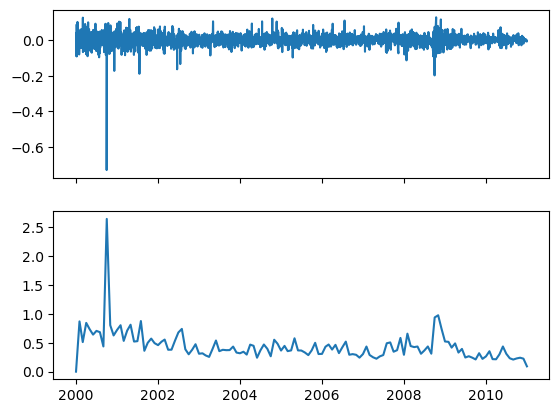

In [48]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def realized_volatility(x):
    """Funcion para calcular la volatilidad realizada"""
    return np.sqrt(np.sum(x**2))

df = yf.download("AAPL",start="1999-12-31", end="2010-12-31", progress=False )

# Obteniendo una columna 
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

# Calculo de rendimientos
df["log_rtn"] = np.log(df.adj_close/df.adj_close.shift(1))

# Calculo de la volatilidad realizada mensual
df_rv = df.groupby(pd.Grouper(freq="M")).apply(realized_volatility)
df_rv.rename(columns={"log_rtn":"rv"}, inplace=True)

# Anualizando los valores
df_rv.rv = df_rv.rv * np.sqrt(12)

# Graficando resultados
fig, ax = plt.subplots(2, 1, sharex=True) 
ax[0].plot(df.log_rtn)
ax[1].plot(df_rv.rv)

plt.show()
